### Proyecto: **Clasificación**

Clasificación de 3 datasets con 9 distintos modelos

- Diabetes dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database <br/>
- Ionosphere dataset: https://archive.ics.uci.edu/ml/datasets/ionosphere <br/>
- Credit Approval dataset: https://archive.ics.uci.edu/ml/datasets/Credit+Approval

In [33]:
import pandas as pd 
import numpy as np
import math
from itertools import combinations

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

Importando datasets

In [34]:
# dataset Diabetes
X_dia = pd.read_csv("diabetes.csv", header=0)
y_dia = X_dia['Outcome'].copy()
X_dia.drop('Outcome', axis='columns', inplace = True)
X_dia.columns = range(X_dia.shape[1])

# dataset Ionosphere
X_ion = pd.read_csv("ionosphere.data", header = None)
y_ion = X_ion[34].copy()
X_ion.drop(34, axis='columns', inplace = True)
for i in range(len(y_ion)):
    if y_ion.iloc[i] == 'g':
        y_ion.iloc[i] = 1
    else:
        y_ion.iloc[i] = 0

# dataset Credit approval
X_cre = pd.read_csv("crx.data", header = None)

Eliminamos patrones con valores NaN (dados por el caracter '?'). Cambiamos las variables categóricas del dataset "Credit approval". 

In [35]:
indexEliminate = []
for i in range(X_cre.shape[0]):
    for j in range(X_cre.shape[1]):
        if X_cre[j].iloc[i] == '?':
            indexEliminate.append(i)    
            break

X_cre.drop(indexEliminate, axis = 'index', inplace = True)
X_cre.index = np.array(range(X_cre.shape[0]))

In [36]:
labelEncoder = LabelEncoder()
for i in [0,3,4,5,6,8,9,11,12]:
    # Para cada columna con datos categoricos, cambiar datos a numeros
    attribute = labelEncoder.fit_transform(X_cre[i])
    X_cre[i] = attribute

y_cre = X_cre[15].copy()
X_cre.drop(15, axis='columns', inplace = True)

for i in range(len(y_cre)):
    if y_cre.iloc[i] == '+':
        y_cre.iloc[i] = 1
    else:
        y_cre.iloc[i] = 0

In [37]:
y_ion = y_ion.astype(int, copy=False)
y_cre = y_cre.astype(int, copy=False)
X_cre = X_cre.astype({1:float,13:'int32'}, copy=False)

In [38]:
X = [X_dia, X_ion, X_cre]
y = [y_dia, y_ion, y_cre]

División de 5 datasets. Para esto nos apoyamos de la función `StratifiedShuffleSplit` de Scikit-Learn (ver <a href = https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html >documentación</a>)

In [39]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0)

Ejemplo de cómo funciona `StratifiedShuffleSplit`:

In [40]:
for train_index, test_index in sss.split(X_cre, y_cre):
    print(train_index[:10])
    print(test_index[:10])

[391 372 426 351 318 124 546 284 547 169]
[648 250 367 230 498 240 304 275 395 623]
[478 500 132 204 479 128 141 199 402 224]
[ 38 612 429 274 157  54  99 574 575 422]
[532 147 120  55 383 439  15  90 329 192]
[ 95 244 380 180 291 306 466 343 381 387]
[477 616 631 261 375  56 144 391 466 189]
[242 452 204  32 181 291 111 608 486  69]
[508 445 474 457 614 266  87 105 172 206]
[579 469 440 443 208 335 291 226 179 102]


In [41]:
for train_index, test_index in sss.split(X_dia, y_dia):
    print(train_index[:10])
    print(test_index[:10])

[250  72 584 348 298 601 410 531 337 480]
[235 427 455 153 333 692 107  78 386 720]
[408 623 238 582  74  14 121 278 210 682]
[467 478 628 451  89 375 273 320 504 669]
[223 545 664 703 682 148 623 104 717 247]
[621 412 262 639 261 681 356 125 424 180]
[624  58 581 468 752 406 219 754 658 319]
[751  73 404 328   7 477 184 175 322 707]
[141 650 348 444 296 533 301 661 190  30]
[167 511 676 171 267 439 660 577 538 432]


## Clasificación con un modelo

In [44]:
# Clasificadores
classifier = [] 
classifier.append(NearestCentroid())
classifier.append(KNeighborsClassifier(n_neighbors=1))
classifier.append(KNeighborsClassifier(n_neighbors=3))
classifier.append(KNeighborsClassifier(n_neighbors=5))
classifier.append(GaussianNB())
classifier.append(DecisionTreeClassifier(criterion='entropy', max_depth=2))
classifier.append(DecisionTreeClassifier(criterion='entropy', max_depth=4))
classifier.append(MLPClassifier(hidden_layer_sizes=(200,), max_iter=2000, activation='relu', solver='sgd'))
classifier.append(MLPClassifier(hidden_layer_sizes=(30,30), max_iter=2000, activation='tanh', solver='sgd'))

# Para escalar datos
scaler = MinMaxScaler()

Exploración de parámetros

classifier[5] = DecisionTreeClassifier(criterion='entropy', max_depth=2)
classifier[6] = DecisionTreeClassifier(criterion='entropy', max_depth=4)
classifier[7] = MLPClassifier(hidden_layer_sizes=(200,), max_iter=2000, activation='relu', solver='sgd')
classifier[8] = MLPClassifier(hidden_layer_sizes=(30,30), max_iter=2000, activation='tanh', solver='sgd')

dataset = 2
clr = 8
cm_train = np.zeros((2,2))
cm_test = np.zeros((2,2))
acc_train = 0
acc_test = 0

for train_index, test_index in sss.split(X[dataset], y[dataset]):
    X_train = scaler.fit_transform(X[dataset].iloc[train_index])
    X_test = scaler.transform(X[dataset].iloc[test_index])
    y_train = y[dataset].iloc[train_index]
    y_test = y[dataset].iloc[test_index]
    
    classifier[clr].fit(X_train, y_train)
    y_pred_train = classifier[clr].predict(X_train)
    y_pred_test = classifier[clr].predict(X_test)
    
    cm_train += confusion_matrix(y_train, y_pred_train)
    cm_test += confusion_matrix(y_test, y_pred_test)
    
    acc_train += accuracy_score(y_train, y_pred_train)
    acc_test += accuracy_score(y_test, y_pred_test)
    
cm_train /= 5.0
cm_test /= 5.0
acc_train /= 5.0
acc_test /= 5.0

print("Accuracy train = ", acc_train)
print("Accuracy test = ", acc_test)
print("CM train = ", cm_train)
print("CM test = ", cm_test)

In [45]:
# confusionMatrix_train[p][i] es la matriz de confusion promedio con dataset p y clasificador i para los conjuntos de entrenamiento
confusionMatrix_train = [[], [], []]
# confusionMatrix_test[p][i] es la matriz de confusion promedio con dataset p y clasificador i para los conjuntos de prueba
confusionMatrix_test = [[], [], []]
# y_predict_train[p][j][i] es la prediccion sobre el j-esimo conjunto de entrenamiento del dataset p con el clasificador i
y_predict_train = [[], [], []]
# y_predict_test[p][j][i] es la prediccion sobre el j-esimo conjunto de prueba del dataset p con el clasificador i
y_predict_test = [[], [], []]
# y_real_train[p][j] son las etiquetas j-esimo conjunto de entrenamiento del dataset p
y_real_train = [[], [], []]
# y_real_test[p][j] son las etiquetas j-esimo conjunto de prueba del dataset p
y_real_test = [[], [], []]

# iteramos sobre los datasets
for p in range(3):
    
    # inicializacion de matrices de confusion promedio
    for i in range(9):
        confusionMatrix_train[p].append(np.zeros((2,2)))
        confusionMatrix_test[p].append(np.zeros((2,2)))
    
    j = 0 # contador para saber en que numero de particion estamos (j=0,1,2,3,4)
    
    # iteramos sobre las particiones estratificadas de los datasets
    for train_index, test_index in sss.split(X[p], y[p]):
        
        y_predict_train[p].append([])
        y_predict_test[p].append([])
        
        # escalamos dataset
        X_train = scaler.fit_transform(X[p].iloc[train_index])
        X_test = scaler.transform(X[p].iloc[test_index])
        y_train = y[p].iloc[train_index]
        y_test = y[p].iloc[test_index]
        
        y_real_train[p].append(y_train)
        y_real_test[p].append(y_test)
        
        # iteramos sobre los distintos clasificadores
        for i in range(9):
    
            classifier[i].fit(X_train, y_train)
            y_pred_train = classifier[i].predict(X_train)
            y_pred_test = classifier[i].predict(X_test)
            
            cm_train = confusion_matrix(y_train, y_pred_train)
            cm_test = confusion_matrix(y_test, y_pred_test)
            
            y_predict_train[p][j].append(y_pred_train)
            y_predict_test[p][j].append(y_pred_test)
            
            confusionMatrix_train[p][i] += cm_train
            confusionMatrix_test[p][i] += cm_test
        
        j+=1
    
    for i in range(9):
        confusionMatrix_train[p][i] /= 5.0
        confusionMatrix_test[p][i] /= 5.0
    

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Matrices de confusión

In [63]:
dataset = 1
i = 4 # modelo
print("Confusion Matrix de entrenamiento con el modelo ", i, ": ")
print(confusionMatrix_train[dataset][i])
print("Confusion Matrix de prueba con el modelo ", i, ": ")
print(confusionMatrix_test[dataset][i])

Confusion Matrix de entrenamiento con el modelo  4 : 
[[ 62.6  21.4]
 [  2.8 148.2]]
Confusion Matrix de prueba con el modelo  4 : 
[[33.2  8.8]
 [ 3.2 70.8]]


## Gráficas de cobertura

In [47]:
# Name of classifiers
namesCL = {0:"Nearest Centroid", 1: "KNN (k=1)", 2: "KNN (k=3)", 3:"KNN (k=5)", 4: "Naive Bayes", 5: "Decision Tree 1", 6:"Decision Tree 2", 
          7: "Neural Network 1", 8: "Neural Network 2"}

### Diabetes dataset

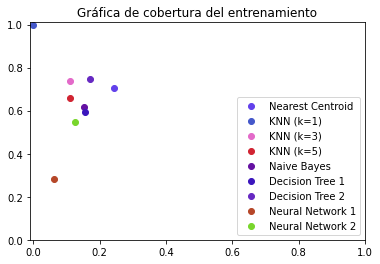

In [48]:
x = [confusionMatrix_train[0][i][0][1]/(confusionMatrix_train[0][i][0][0]+confusionMatrix_train[0][i][0][1]) for i in range(9)]
y = [confusionMatrix_train[0][i][1][1]/(confusionMatrix_train[0][i][1][0]+confusionMatrix_train[0][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([-0.01, 1, 0, 1.01])
plt.title("Gráfica de cobertura del entrenamiento")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

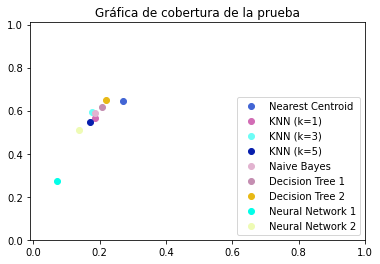

In [49]:
x = [confusionMatrix_test[0][i][0][1]/(confusionMatrix_test[0][i][0][0]+confusionMatrix_test[0][i][0][1]) for i in range(9)]
y = [confusionMatrix_test[0][i][1][1]/(confusionMatrix_test[0][i][1][0]+confusionMatrix_test[0][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([-0.01, 1, 0, 1.01])
plt.title("Gráfica de cobertura de la prueba")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

### Ionosphere dataset

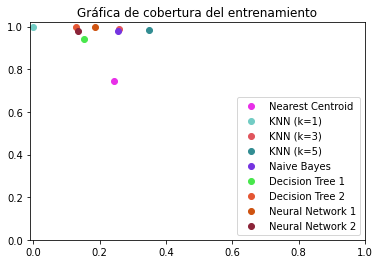

In [50]:
x = [confusionMatrix_train[1][i][0][1]/(confusionMatrix_train[1][i][0][0]+confusionMatrix_train[1][i][0][1]) for i in range(9)]
y = [confusionMatrix_train[1][i][1][1]/(confusionMatrix_train[1][i][1][0]+confusionMatrix_train[1][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([-0.01, 1.0, 0, 1.02])
plt.title("Gráfica de cobertura del entrenamiento")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

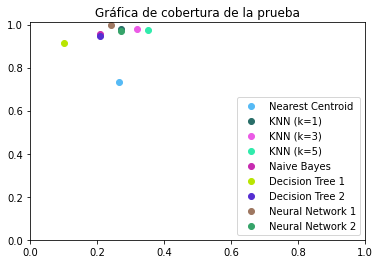

In [51]:
x = [confusionMatrix_test[1][i][0][1]/(confusionMatrix_test[1][i][0][0]+confusionMatrix_test[1][i][0][1]) for i in range(9)]
y = [confusionMatrix_test[1][i][1][1]/(confusionMatrix_test[1][i][1][0]+confusionMatrix_test[1][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([0, 1, 0, 1.01])
plt.title("Gráfica de cobertura de la prueba")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

### Credit approval dataset

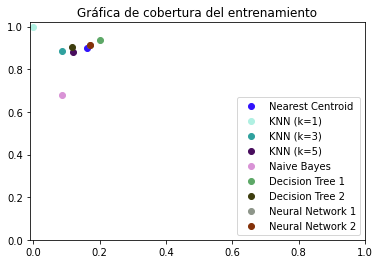

In [52]:
x = [confusionMatrix_train[2][i][0][1]/(confusionMatrix_train[2][i][0][0]+confusionMatrix_train[2][i][0][1]) for i in range(9)]
y = [confusionMatrix_train[2][i][1][1]/(confusionMatrix_train[2][i][1][0]+confusionMatrix_train[2][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([-0.01, 1.0, 0, 1.02])
plt.title("Gráfica de cobertura del entrenamiento")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

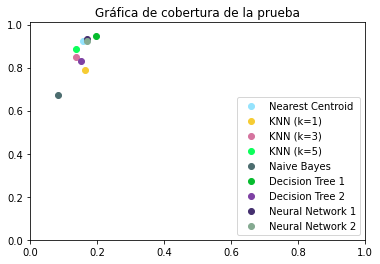

In [53]:
x = [confusionMatrix_test[2][i][0][1]/(confusionMatrix_test[2][i][0][0]+confusionMatrix_test[2][i][0][1]) for i in range(9)]
y = [confusionMatrix_test[2][i][1][1]/(confusionMatrix_test[2][i][1][0]+confusionMatrix_test[2][i][1][1])  for i in range(9)]
sctr = []
for i in range(9):
    sctr.append(plt.scatter(x[i],y[i], color=np.random.random(3)))
plt.axis([0, 1, 0, 1.01])
plt.title("Gráfica de cobertura de la prueba")
plt.legend([sctr[i] for i in range(9)],namesCL.values(), loc ="lower right") 
plt.show()

## Clasificación por votación de varios modelos

In [54]:
# Funcion para clasificar por votacion el j-esimo conjunto de entrenamiento y prueba del dataset p usando la combinacion comb de clasificadores
def votes(y_predict_train, y_predict_test, comb, p, j):
    n = len(y_predict_train[p][j][0])
    m = len(y_predict_test[p][j][0])
    
    y_pred_train = np.zeros(n)
    y_pred_test = np.zeros(m)
    
    for i in comb:
        y_pred_train += y_predict_train[p][j][i]
        y_pred_test += y_predict_test[p][j][i]
        
    for k in range(n):
        if y_pred_train[k] > len(comb)/2.0:
            y_pred_train[k] = 1
        elif y_pred_train[k] == len(comb)/2:
            y_pred_train[k] = -1 # Empate en la votacion
        else:
            y_pred_train[k] = 0
    
    for k in range(m):
        if y_pred_test[k] > len(comb)/2.0:
            y_pred_test[k] = 1
        elif y_pred_test[k] == len(comb)/2:
            y_pred_test[k] = -1 # Empate en la votacion
        else:
            y_pred_test[k] = 0
    
    return y_pred_train, y_pred_test

In [55]:
# acc_prom_train[p][comb] es el acc promedio usando la combinacion comb (una tupla con indices del 0 al 9) de clasificadores sobre el dataset p 
# con los conjuntos de entrenamiento
acc_prom_train = [{}, {}, {}] 
# acc_prom_test[p][comb] es el acc promedio usando la combinacion comb (una tupla con indices del 0 al 9) de clasificadores sobre el dataset p
# con los conjuntos de prueba
acc_prom_test = [{}, {}, {}] 

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)
    for comb in allCombinations:
        for p in range(3):
            acc_prom_train[p][comb] = 0.0
            acc_prom_test[p][comb] = 0.0
            
            for j in range(5):
                y_pred_train, y_pred_test = votes(y_predict_train, y_predict_test, comb, p, j)
                acc_train = accuracy_score(y_real_train[p][j], y_pred_train)
                acc_test = accuracy_score(y_real_test[p][j], y_pred_test)
                
                acc_prom_train[p][comb] += acc_train
                acc_prom_test[p][comb] += acc_test
            
            acc_prom_train[p][comb] /= 5
            acc_prom_test[p][comb] /= 5

In [56]:
dataset = 0
comb = (0,1,5)
print("Acc promedio en entrenamiento con combinación ", comb, ": ", acc_prom_train[dataset][comb])
print("Acc promedio en prueba con combinación ", comb, ": ", acc_prom_test[dataset][comb])

Acc promedio en entrenamiento con combinación  (0, 1, 5) :  0.8645914396887161
Acc promedio en prueba con combinación  (0, 1, 5) :  0.7480314960629921


### Dataset Diabetes

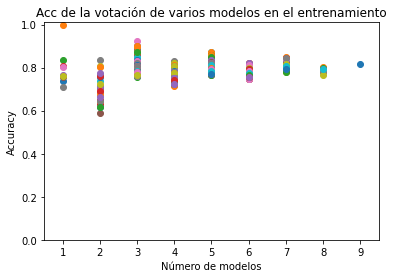

In [57]:
dataset = 0

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_train[dataset][comb])
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en el entrenamiento")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()

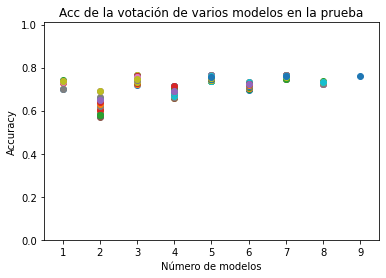

In [58]:
dataset = 0

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_test[dataset][comb])#, color=np.random.random(3)))
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en la prueba")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()

### Ionosphere dataset

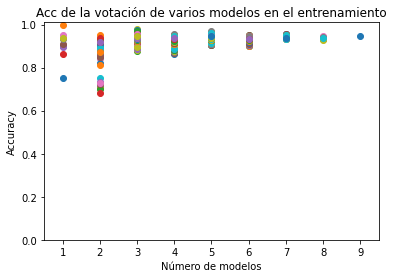

In [59]:
dataset = 1

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_train[dataset][comb])
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en el entrenamiento")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()

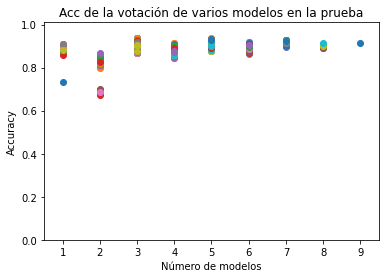

In [60]:
dataset = 1

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_test[dataset][comb])#, color=np.random.random(3)))
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en la prueba")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()

### Credit approval dataset

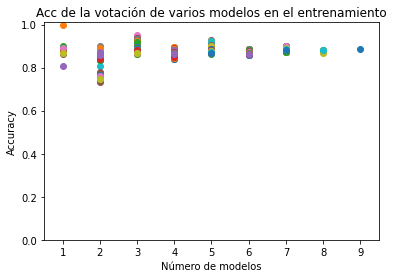

In [61]:
dataset = 2

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_train[dataset][comb])
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en el entrenamiento")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()

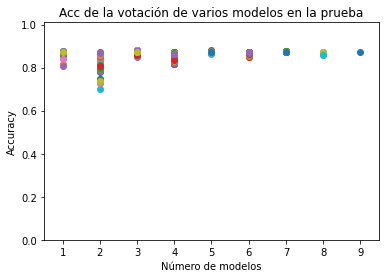

In [62]:
dataset = 2

for e in range(1,10):
    allCombinations = combinations([i for i in range(9)], e)

    for comb in allCombinations:
        plt.scatter(e, acc_prom_test[dataset][comb])#, color=np.random.random(3)))
        
plt.axis([0.5, 9.5, 0, 1.01])
plt.title("Acc de la votación de varios modelos en la prueba")
plt.xlabel("Número de modelos")
plt.ylabel("Accuracy")
plt.show()